In [1]:
!nvidia-smi

Wed Mar 16 08:10:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dense,Dropout,Flatten,Lambda,Input
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [ ]:
#! pip install tensorflow_hub
#!pip install tensorflow-gpu

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [6]:
IMAGE_SIZE=224
train_path='/content/drive/MyDrive/Data Science project/cotton Disease pred/train'
test_path='/content/drive/MyDrive/Data Science project/cotton Disease pred/test'

In [8]:
inception=InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),weights='imagenet',include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [11]:
#here we have existing weights and they are trained so we dont want to train our weights.we just want to train our last layer
for layer in inception.layers:
  layer.trainable=False

In [12]:
#useful in getting no of output classes
folders=glob('/content/drive/MyDrive/Data Science project/cotton Disease pred/train/*')

In [13]:
X=Flatten()(inception.output)


In [14]:
prediction=Dense(len(folders),activation='softmax')(X)

In [16]:
model= Model(inputs=inception.input,outputs=prediction)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
#Data Augmentation
train_data=ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True)
test_data=ImageDataGenerator(rescale=1./255)

In [21]:
train_dataset=train_data.flow_from_directory('/content/drive/MyDrive/Data Science project/cotton Disease pred/train',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 1345 images belonging to 4 classes.


In [22]:
test_dataset=test_data.flow_from_directory('/content/drive/MyDrive/Data Science project/cotton Disease pred/test',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 12 images belonging to 4 classes.


In [23]:
train_dataset.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [24]:
#this shows augumented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

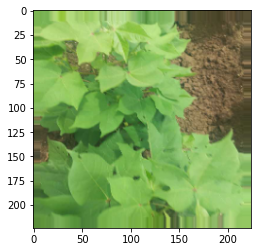

In [25]:
plt.imshow(train_dataset[0][0][0])

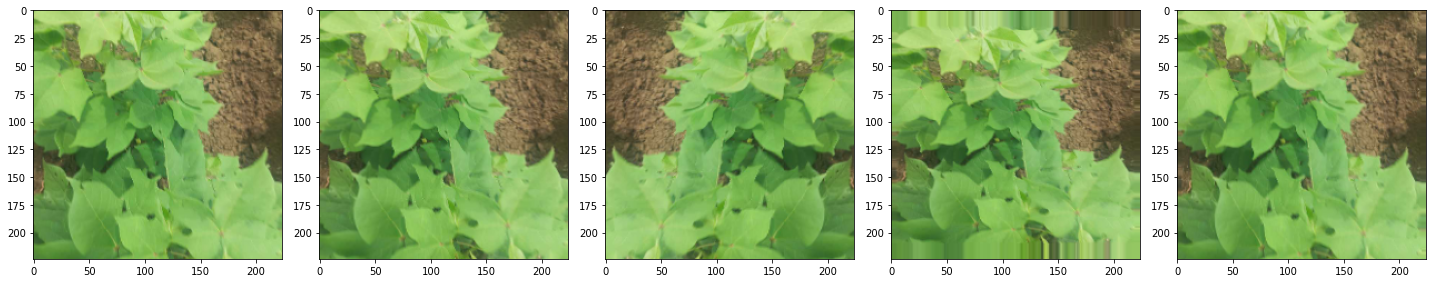

In [26]:
images = [train_dataset[0][0][0] for i in range(5)]
plotImages(images)

In [27]:
import keras
from keras.callbacks import ModelCheckpoint

In [28]:
model_path = '/content/drive/MyDrive/Data Science project/cotton Disease pred/model_inceptionv3.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [29]:
r=model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=len(train_dataset),
    validation_steps=len(test_dataset)
)

Epoch 1/20
43/43 [==============================] - 140s 3s/step - loss: 2.8692 - accuracy: 0.7249 - val_loss: 11.6885 - val_accuracy: 0.6667
Epoch 2/20
43/43 [==============================] - 27s 627ms/step - loss: 0.6297 - accuracy: 0.8959 - val_loss: 10.9992 - val_accuracy: 0.7500
Epoch 3/20
43/43 [==============================] - 27s 631ms/step - loss: 0.3268 - accuracy: 0.9301 - val_loss: 10.5916 - val_accuracy: 0.8333
Epoch 4/20
43/43 [==============================] - 26s 607ms/step - loss: 0.2840 - accuracy: 0.9405 - val_loss: 10.6719 - val_accuracy: 0.9167
Epoch 5/20
43/43 [==============================] - 26s 603ms/step - loss: 0.3173 - accuracy: 0.9398 - val_loss: 10.3441 - val_accuracy: 0.9167
Epoch 6/20
43/43 [==============================] - 26s 604ms/step - loss: 0.4757 - accuracy: 0.9264 - val_loss: 10.5579 - val_accuracy: 0.9167
Epoch 7/20
43/43 [==============================] - 26s 612ms/step - loss: 0.5259 - accuracy: 0.9279 - val_loss: 10.9123 - val_accuracy: 0

In [30]:
loss=r.history['loss']
val_loss=r.history['val_loss'],
acc=r.history['accuracy']
val_acc=r.history['val_accuracy']

In [31]:
EPOCHS=20

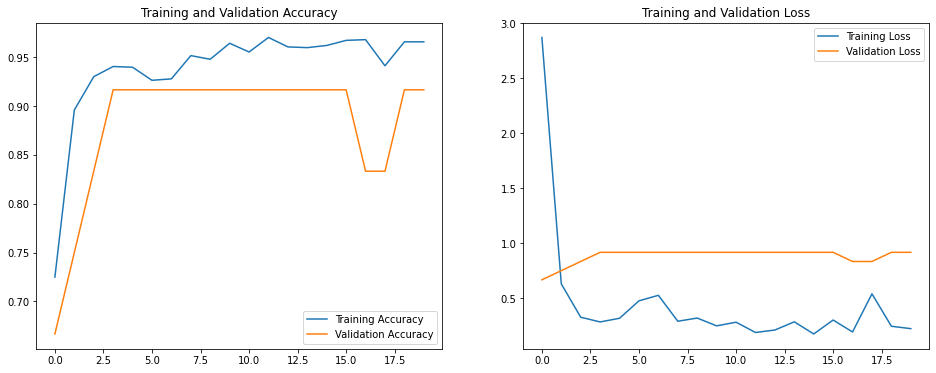

In [32]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_acc, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
from tensorflow.keras.models import load_model

In [34]:
model.save(model_path)